In [1]:
import sys
sys.path.append('LightGCN-PyTorch-master//code')
sys.path.append('RecSys2019_DeepLearning_Evaluation-master')
sys.argv.pop()
sys.argv.pop()
sys.argv.extend(['--decay', '1e-4', '--lr', '0.001', '--layer', '3', '--seed', '2020', '--dataset', "gowalla", 
                 '--topks', "[20]", '--recdim', '64'])

from SLIM_ElasticNet.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender
from EASE_R.EASE_R_Recommender import EASE_R_Recommender
import time

In [2]:
from dataloader import Loader

In [3]:
# Gowalla
# Yelp2018
# Amazon-Book
dataset = Loader(path='./LightGCN-PyTorch-master/data/gowalla')

loading [./LightGCN-PyTorch-master/data/gowalla]
810128 interactions for training
217242 interactions for testing
29858 users
40981 items
gowalla Sparsity : 0.0008396216228570436
gowalla is ready to go


In [4]:
import utils
import numpy as np
import world
from tqdm.notebook import tqdm

def test_one_batch(X):
    sorted_items = np.array(X[0])
    groundTrue = X[1]
    r = utils.getLabel(groundTrue, sorted_items)
    pre, recall, ndcg = [], [], []
    for k in world.topks:
        ret = utils.RecallPrecision_ATk(groundTrue, r, k)
        pre.append(ret['precision'])
        recall.append(ret['recall'])
        ndcg.append(utils.NDCGatK_r(groundTrue,r,k))
    return {'recall':np.array(recall), 
            'precision':np.array(pre), 
            'ndcg':np.array(ndcg)}

def test(dataset, Recmodel, w=None, multicore=0):
    u_batch_size = world.config['test_u_batch_size']
    testDict: dict = dataset.testDict
    # eval mode with no dropout
    max_K = max(world.topks)
    if multicore == 1:
        pool = multiprocessing.Pool(CORES)
    results = {'precision': np.zeros(len(world.topks)),
               'recall': np.zeros(len(world.topks)),
               'ndcg': np.zeros(len(world.topks))}
    users = list(testDict.keys())
    try:
        assert u_batch_size <= len(users) / 10
    except AssertionError:
        print(f"test_u_batch_size is too big for this dataset, try a small one {len(users) // 10}")
    users_list = []
    rating_list = []
    groundTrue_list = []
    # auc_record = []
    # ratings = []
    total_batch = len(users) // u_batch_size + 1
    for batch_users in tqdm(utils.minibatch(users, batch_size=u_batch_size), total=total_batch):
        allPos = dataset.getUserPosItems(batch_users)
        groundTrue = [testDict[u] for u in batch_users]
        rating_K = Recmodel.recommend(batch_users, cutoff=max_K)
        users_list.append(batch_users)
        rating_list.append(rating_K)
        groundTrue_list.append(groundTrue)
    assert total_batch == len(users_list)
    X = zip(rating_list, groundTrue_list)
    pre_results = map(test_one_batch, X)
    scale = float(u_batch_size/len(users))
    for result in pre_results:
        results['recall'] += result['recall']
        results['precision'] += result['precision']
        results['ndcg'] += result['ndcg']
    results['recall'] /= float(len(users))
    results['precision'] /= float(len(users))
    results['ndcg'] /= float(len(users))
    # results['auc'] = np.mean(auc_record)
    print(results)
    return results

Cpp extension not loaded


In [7]:
# Gowalla - 'alpha': 1, 'beta': 0
# Yelp2018 - 'alpha': 0.731523, 'beta': 0.415935
# Amazon-Book - 'alpha': 1, 'beta': 0
recmodel_p3alpha = RP3betaRecommender(dataset.UserItemNet)
recmodel_p3alpha.fit(**{'alpha': 1, 'beta': 0}, topK=10**10)
test(dataset, recmodel_p3alpha)

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

{'precision': array([0.05643546]), 'recall': array([0.18622193]), 'ndcg': array([0.15631148])}


{'precision': array([0.05643546]),
 'recall': array([0.18622193]),
 'ndcg': array([0.15631148])}

In [6]:
# Gowalla - 'alpha': 1, 'beta': 0
# Yelp2018 - 'alpha': 0.731523, 'beta': 0.415935
# Amazon-Book - 'alpha': 1, 'beta': 0
recmodel_ease = EASE_R_Recommender(dataset.UserItemNet)
recmodel_ease.fit(l2_norm=1000.0, topK=None, normalize_matrix=False)
test(dataset, recmodel_ease)

EASE_R_Recommender: Fitting model... 
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 40981 (100.0%), 430.64 column/sec. Elapsed time 1.59 min
EASE_R_Recommender: Fitting model... done in 7.11 min


  0%|          | 0/299 [00:00<?, ?it/s]

{'precision': array([0.03085438]), 'recall': array([0.10202729]), 'ndcg': array([0.07242745])}


{'precision': array([0.03085438]),
 'recall': array([0.10202729]),
 'ndcg': array([0.07242745])}

In [84]:
type(recmodel_ease.W_sparse), type(np.asarray(recmodel_p3alpha.W_sparse.todense()))

(numpy.ndarray, numpy.ndarray)

In [86]:
recmodel_ease.W_sparse = (recmodel_ease.W_sparse + np.asarray(recmodel_p3alpha.W_sparse.todense()))/2

In [87]:
test(dataset, recmodel_ease)

  0%|          | 0/299 [00:00<?, ?it/s]

{'precision': array([0.05576227]), 'recall': array([0.18387079]), 'ndcg': array([0.15323673])}


{'precision': array([0.05576227]),
 'recall': array([0.18387079]),
 'ndcg': array([0.15323673])}

In [5]:
import numpy as np
import scipy.sparse as sp

In [55]:
P = sp.coo_matrix(np.random.randint(0, 2, (4, 4)))

In [56]:
P

<4x4 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in COOrdinate format>

In [57]:
recmodel_p3alpha = RP3betaRecommender(P)
recmodel_p3alpha.fit(**{'alpha': 1, 'beta': 0}, topK=10**10)

  0%|          | 0/1 [00:00<?, ?it/s]

In [58]:
recmodel_ease = EASE_R_Recommender(P)
recmodel_ease.fit(, topK=10**10)

SyntaxError: invalid syntax (1502705973.py, line 2)

In [59]:
recmodel_ease = EASE_R_Recommender(P)
recmodel_ease.fit(l2_norm=0)

EASE_R_Recommender: Fitting model... 
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 4 (100.0%), 5985.44 column/sec. Elapsed time 0.00 sec
EASE_R_Recommender: Fitting model... done in 0.00 sec


In [60]:
recmodel_ease.W_sparse

array([[ 0. , -0. ,  0.5, -0. ],
       [-0. ,  0. , -0.5,  1. ],
       [ 0.5, -0.5,  0. ,  1. ],
       [-0. ,  0.5,  0.5,  0. ]], dtype=float32)

In [12]:
recmodel_p3alpha.W_sparse.todense()

matrix([[0.        , 0.00091884, 0.0032969 , ..., 0.        , 0.        ,
         0.        ],
        [0.00091481, 0.        , 0.00451239, ..., 0.        , 0.        ,
         0.        ],
        [0.00238972, 0.00328517, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32)

In [19]:
Pui = dataset.UserItemNet/dataset.UserItemNet.sum(1)
Piu = dataset.UserItemNet.T
Piu = Piu/Piu.sum(1)

In [7]:
import scipy.sparse as sp

In [ ]:
W_ = Piu @ Pui
diag_idx = np.diag_indices(W_.shape[0])
W_[diag_idx] += 1000
W_ = np.linalg.inv(W_)

In [ ]:
W_ = - W_ / np.diag(W_)
W_[diag_idx] = 0

In [15]:
import pickle
with open('W_.pickle', 'rb') as f:
    W_ = pickle.load(f)

In [20]:
G = Piu @ Pui
del Piu, Pui

In [9]:
np.isclose(G, W_)

matrix([[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]])

In [10]:
recmodel_ease = EASE_R_Recommender(dataset.UserItemNet)

In [16]:
recmodel_ease.W_sparse = sp.csr_matrix(W_)

In [12]:
test(dataset, recmodel_ease)

  0%|          | 0/299 [00:00<?, ?it/s]

{'precision': array([0.05641369]), 'recall': array([0.18615776]), 'ndcg': array([0.15626646])}


{'precision': array([0.05641369]),
 'recall': array([0.18615776]),
 'ndcg': array([0.15626646])}

In [17]:
test(dataset, recmodel_ease)

  0%|          | 0/299 [00:00<?, ?it/s]

{'precision': array([0.05642206]), 'recall': array([0.18619712]), 'ndcg': array([0.15627935])}


{'precision': array([0.05642206]),
 'recall': array([0.18619712]),
 'ndcg': array([0.15627935])}

In [22]:
import matplotlib.pyplot as plt

In [27]:
G

matrix([[0.02958962, 0.00089165, 0.00319935, ..., 0.        , 0.        ,
         0.        ],
        [0.00089165, 0.0253153 , 0.00439816, ..., 0.        , 0.        ,
         0.        ],
        [0.00231064, 0.00317645, 0.0330938 , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.11111111, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.125     ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.07142857]])

In [ ]:
np.correlate(G.flatten(), W_.flatten())

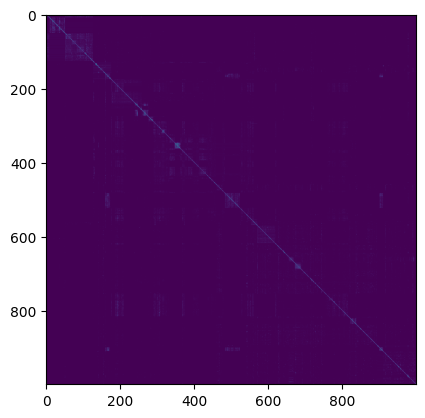

In [29]:
gmax = G[:1000, :1000].max()
gmin = G[:1000, :1000].min()
plt.imshow((G[:1000, :1000] - gmin)/(gmax - gmin))

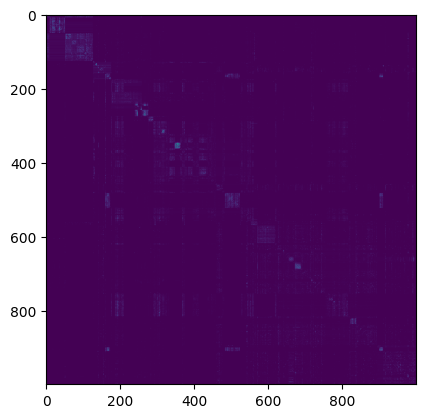

In [30]:
gmax = W_[:1000, :1000].max()
gmin = W_[:1000, :1000].min()
plt.imshow((W_[:1000, :1000] - gmin)/(gmax - gmin))